# Computer Vision Masterclass: Deep Dream

In [ ]:
# 신경망의 은닉층에 액세스해서 그 안에 존재하는 것이 무엇인지 살펴볼 것임.
# 출력층 사용대신 은닉층을 선택하고 그 안에서 계산을 수행.
# 목표는 신경망의 입력층에 이미지를 전송하고 은닉층의 내부에 무엇이 존재하는지 확인하여 원본이미지를 수정하는 것.
# 이미지 분류를 위해 사전 학습된 신경망 사용(전이학습 이용).

## Importing the libraries

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/deepdream

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.17.1'

## Loading the pre-built convolutional neural network

- InceptionNet: https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3
- Original paper: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf
- Imagenet: http://www.image-net.org/

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# include_top=False -> 밀집층이 아닌 합성곱층과 풀링층만 가져옴
# weights='imagenet' -> 신경망 구조의 학습 기반이 되는 데이터셋

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()
# mixed 층은 다른층과 연결된 층(Concatenate)을 뜻함.

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
len(base_model.layers)

311

In [ ]:
# 합성곱 신경망의 첫번째 층에서는 이미지의 일반적인 특성(모서리, 코너 등)을 갖는다.
# 마지막 층은 해당 객체에 대해 좀 더 복잡한 특성을 갖는다.
# Inception 신경망은 mixed 라는 다수의 연결된 층을 갖는다.

In [ ]:
# Relu
#names = ['mixed3', 'mixed5', 'mixed8', 'mixed9']  # 원하는 층을 자유롭게 선택 가능.
# 각각의 mixed 층은 여러 부서로 이루어진 TF팀과 같음. 나중에 나오는 mixed 층일수록 복잡한 특성을 가짐.
names = ['mixed3', 'mixed5'] # 이 2개만 사용해보자. 검증 시에 가장 흥미로운 결괏값을 보여주는 조합만을 남기기 위함.
# 많은 층을 선택할 수록 이미지 생성에 더 오랜 시간이 걸림.

In [ ]:
base_model.input # 신경망의 첫번째 층.

<KerasTensor shape=(None, None, None, 3), dtype=float32, sparse=False, name=keras_tensor>

In [ ]:
layers = [base_model.get_layer(name).output for name in names]

In [ ]:
layers # 각각의 층이 768개의 뉴런으로 이루어져 있음을 알 수 있음.

[<KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_100>,
 <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_164>]

In [ ]:
# 딥드림 모델 생성
deep_dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)
# 딥드림을 통해 작업할 때는 신경망 중간에 있는 몇개의 층을 골라서 하나로 합칠 수 있음.
# 이 신경망은 2개의 출력층을 갖음. <- names = ['mixed3', 'mixed5']

## Loading and pre-processing the image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Computer Vision/Images/StaryNight.jpg',
                                              target_size=(225, 375))
# target_size=(225, 375) -> Inception 신경망에서의 이미지 크기 조건. InceptionNet 공식 문서 참조

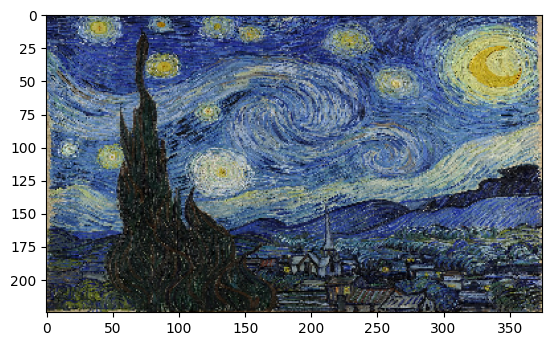

In [ ]:
plt.imshow(image);

In [ ]:
type(image) # PIL은 이미지를 다루는 파이썬 라이브러리

PIL.Image.Image

In [ ]:
image.size

(375, 225)

In [ ]:
image.mode , len(image.mode)
# 'RGB' -> 해당 이미지가 컬러임을 의미
# 3 ->  3개의 채널이 있음.

('RGB', 3)

In [ ]:
list(image.getdata())  # 이미지의 모든 픽셀을 살펴볼 수 있음. (R, G, B)
# image.getdata()은 ImagingCore 클래스를 반환.

[(6, 10, 11),
 (30, 33, 66),
 (35, 46, 66),
 (39, 46, 65),
 (46, 49, 68),
 (23, 27, 39),
 (13, 15, 38),
 (57, 61, 86),
 (85, 88, 97),
 (147, 147, 139),
 (138, 139, 123),
 (112, 116, 117),
 (18, 21, 52),
 (23, 28, 60),
 (85, 96, 116),
 (83, 92, 121),
 (148, 152, 155),
 (29, 32, 63),
 (57, 63, 99),
 (12, 20, 39),
 (34, 39, 69),
 (23, 30, 56),
 (4, 12, 48),
 (25, 32, 74),
 (48, 50, 98),
 (134, 133, 173),
 (127, 132, 152),
 (126, 133, 161),
 (138, 151, 168),
 (64, 76, 126),
 (67, 83, 119),
 (61, 75, 112),
 (73, 90, 134),
 (86, 118, 143),
 (55, 81, 80),
 (136, 155, 135),
 (51, 65, 74),
 (152, 169, 195),
 (156, 176, 211),
 (56, 79, 129),
 (94, 116, 165),
 (70, 94, 120),
 (160, 173, 189),
 (142, 156, 185),
 (92, 118, 135),
 (50, 74, 118),
 (107, 132, 162),
 (101, 122, 153),
 (27, 36, 67),
 (34, 44, 79),
 (97, 114, 140),
 (21, 41, 66),
 (51, 60, 101),
 (50, 56, 104),
 (34, 39, 68),
 (22, 24, 45),
 (3, 3, 29),
 (4, 7, 22),
 (28, 37, 34),
 (19, 27, 29),
 (19, 25, 41),
 (43, 49, 75),
 (93, 104, 1

In [ ]:
# PIL 타입을 텐서플로 작업에 맞게 넘파이 타입으로 변환해야 함.
image = tf.keras.preprocessing.image.img_to_array(image)

In [ ]:
type(image)

numpy.ndarray

In [ ]:
image.shape  # PIL에서는 이미지 shape를 보기 위해 size를 입력했었음.

(225, 375, 3)

In [ ]:
image.min(), image.max() # 픽셀의 최솟값과 최댓값
# 255... 정규화하지 않으면 신경망 처리시간이 너무 오래 걸림.

(0.0, 255.0)

In [ ]:
# image = image / 255  # 이거 사용 안함. Inception 신경망을 사용하기 때문.
image = tf.keras.applications.inception_v3.preprocess_input(image)
# 해당 이미지의 모든 픽셀이 논문에 나온 것과 같이 원래의 아키텍처에서 동일한 전처리 과정을 거치게 됨.
# 앞으로도 이 알고리즘을 사용할 때 preprocess_input()를 사용하도록 하자

In [ ]:
image.min(), image.max()
# 보통의 정규화와는 좀 다름. 이런 이유로 inception_v3 신경망에서는 preprocess_input() 쓰는 것이 중요.

(-1.0, 1.0)

## Getting the activations

In [ ]:
# 활성화 값 얻기

In [ ]:
image.shape

(225, 375, 3)

In [ ]:
image_batch = tf.expand_dims(image, axis=0)
# 넘파에도 expand_dims 함수 있음.
# 여기서는 그냥 모두 텐서플로 함수를 이용할 것임.

In [ ]:
image_batch.shape

TensorShape([1, 225, 375, 3])

In [ ]:
activations = deep_dream_model.predict(image_batch)  # 활성화 값 획득.
# 이미지를 신경망으로 전달. 입력층이 이미지의 모든 픽셀을 전달받음.
# 모든 계산은 합성곱층과 풀링층에서 수행되고 relu 활성화 함수의 적용에 해당하는 값을 도출함.
# 전통적인 신경망에서는 이미지를 전송하면 신경망의 마지막 층에서 출력값을 얻음.
# 이 신경망의 경우에는 출력값의 결과를 사용자가 선택한 층(mixed3, mixed5)에서 얻을 수 있음.
# 선택한 각각의 층이 relu 활성화 함수의 결괏값을 가짐.

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [ ]:
deep_dream_model.outputs  # 선택한 층 재확인

[<KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_100>,
 <KerasTensor shape=(None, None, None, 768), dtype=float32, sparse=False, name=keras_tensor_164>]

In [ ]:
len(activations) # 2개의 층이 존재하므로 2가 나옴

2

In [ ]:
activations[0] # 첫번째 층인 mixed3에 대한 relu 함수 적용값.

array([[[[0.59060764, 0.5348789 , 0.        , ..., 1.6520486 ,
          0.        , 0.6775781 ],
         [1.0953629 , 0.        , 1.2273148 , ..., 0.7965105 ,
          0.        , 0.6775781 ],
         [2.041579  , 0.        , 0.30758685, ..., 1.5217929 ,
          0.09386969, 0.11234212],
         ...,
         [1.4007621 , 0.        , 0.        , ..., 1.4881555 ,
          1.601668  , 0.14049697],
         [1.4495722 , 0.        , 0.38680896, ..., 1.5633023 ,
          1.601668  , 0.        ],
         [1.9167843 , 0.        , 0.4373698 , ..., 1.5633023 ,
          1.0496807 , 0.36565349]],

        [[0.        , 0.        , 0.        , ..., 0.6401287 ,
          0.        , 0.3896995 ],
         [0.        , 0.7270159 , 0.        , ..., 0.7965105 ,
          0.        , 0.2540912 ],
         [0.        , 0.        , 0.        , ..., 0.7965105 ,
          0.        , 0.11234212],
         ...,
         [1.8988523 , 0.        , 0.        , ..., 0.18635213,
          0.05853283, 0.7

In [ ]:
activations[0].shape, activations[1].shape
# 각각의 층이 768개의 활성화 값을 가짐.
# 12X21: 이미지의 차원

((1, 12, 21, 768), (1, 12, 21, 768))

## Calculating the loss

In [ ]:
# 손실 = 오차
# 통상적으로 손실값은 기대 결과값과 신경망의 예측값을 비교하여 계산
# 딥드림에서는 이미지의 픽셀을 변경하기 위해 이 계산을 함.
# 예측은 안함. 즉, 기대 결과값과 신경망의 예측값을 비교하지 않을 것임.
# 기대 결과값이 없기 때문.
# 손실이라는 동일한 용어를 사용하지만 실제로는 어떠한 오차도 계산 안함.
# 768개의 활성화 값이 있는데 손실함수의 값을 나타낼 단일값이 필요함.
# 딥드림에서는 활성화 값을 이미지와 비교하여 손실값을 갱신함.
# 일단 각 층의 평균을 계산해보자. 그 후 각 층의 평균값을 더함.

In [ ]:
def calculate_loss(image, network):
    image_batch = tf.expand_dims(image, axis=0)
    activations = network(image_batch)

    losses = []
    for act in activations: # act는 활성화를 의미
        loss = tf.math.reduce_mean(act) # 모든 값을 받아 전체 수량인 768로 나눠서 평균을 계산.
        losses.append(loss)

    #print(losses) # 2개의 값이 나옴. 각각 첫번째 층, 두번째 층의 평균.
    #print(np.shape(losses)) # 2가 나옴.
    #print(tf.reduce_sum(losses))  # 두 값을 더함.

    return tf.reduce_sum(losses)

In [ ]:
loss = calculate_loss(image, deep_dream_model)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.61807656>

## Gradient ascent

In [ ]:
# 통상적인 신경망에서는 경사하강법을 사용하여 오류를 최소화하는 것이 목표
# 전역 최솟값에 도달하기 위해 편미분을 사용하여 곡선의 기울기를 계산함.
# 딥드림에서는 이 값을 극대화하는 것이 목표. 경사 상승법.
# 손실값을 극대화하면 이미지의 각 부분을 강조하게 됨.
# 위에서 이 손실을 계산하였고, 그 값을 이미지에 추가하여 입력이미지의 픽셀을 변경할 것임.
# 그래이디언트 값을 계산한 뒤, 입력 이미지의 픽셀을 변경하는 것은 딥드림에서 가장 중요한 개념 중 하나.

In [ ]:
# 경사 상승법 알고리즘 구현
@tf.function # 텐서플로 라이브러리의 특정 코드. 값들을 변경한 이후에도 유지할 수 있도록 전역변수인 것처럼 정의됨.
def deep_dream(network, image, learning_rate):
    with tf.GradientTape() as tape: # 텐서플로의 클래스. 그래디언트에 접근
        tape.watch(image) # 에포크 수를 토대로 이 함수를 몇차례 호출하게 됨. watch()를 사용하지 않으면 여기에 이미지를 보낸 뒤 다음번 에포크에서 픽셀 변경 시 변경내용을 잃게 됨.
        loss = calculate_loss(image, network) # 이 함수가 호출될 때마다 각 층의 값들을 합산한 결과를 갖게 됨.

    gradients = tape.gradient(loss, image) # 미분을 계산하기 위한 텐서플로 함수. gradients 변수는 그래디언트의 방향을 가리키게 됨.
    gradients /= tf.math.reduce_std(gradients) # 그래디언트 갱신하기위해 표준편차로 나눠줌. 데이터를 표준화.

    image = image + gradients * learning_rate # 이미지의 각 픽셀을 갱신. like 통상적인 신경망의 가중치 갱신
    # 딥드림은 가중치를 갱신하지 않으므로 weight(n+1) = weight(n) + (learning_rate*input*error) 이라는 오류개념을 사용하지 않음.
    # 딥드림에서는 픽셀을 갱신.
    # 단, 이 계산을 실행하면 -1~1 범위를 벗어난 값이 나올 수 있음.
    # 이미지 로드 및 전처리 부분에서 보았듯이 이미지 표준화 이후 -1~1사이의 값을 가졌음.
    image = tf.clip_by_value(image, -1, 1) # 그래서 이 함수를 사용하여 맞춰줌.

    return loss, image

In [ ]:
# 역변환 함수 구현
# 맷플롯립으로 이미지를 출력하기 위해서는 표준화(-1~1)한 픽셀값들을 원본 형식으로 변환해야 함.
def inverse_transform(image):
    image = 255 * (image + 1.0) / 2.0 # -1~1 범위의 수를 원본형태로 변환. 데이터 역변환을 위해 사전에 구축되어 있던 방정식.
    return tf.cast(image, tf.uint8) # 픽셀들을 정수형 값으로 변환

In [ ]:
def run_deep_dream(network, image, epochs, learning_rate):
    for epoch in range(epochs):
        loss, image = deep_dream(network, image, learning_rate)

        if epoch % 200 == 0: # 200 에포크 이후 이미지 출력
            plt.figure(figsize=(12,12))
            plt.imshow(inverse_transform(image))
            plt.show()
            print('Epoch {}, loss {}'.format(epoch, loss))

## Generating images

In [ ]:
image.shape, type(image) # run_deep_dream()을 실행하려면 shape와 type이 numpy형식 이어야 함.

((225, 375, 3), numpy.ndarray)

In [ ]:
run_deep_dream(network=deep_dream_model, image=image, epochs=8000, learning_rate=0.001)
# 에포크를 크게 하면 이미지에 객체가 매우 밀집되어 식별하기 매우 어렵게 됨.
# 학습률을 크게 하면 이미지가 더 많이 변경됨. 0.1로도 한번 해보기. 이것도 큰 수임.
# 이미지에 매우 많은 객체들이 생성되어 각각을 식별해낼 수 없울 것임.
# 따라서 학습률은 좋은 이미지를 생성할 때 매우 중요한 매개변수.
# 학습률이 낮으면 이미지 생성 시 시간이 걸리지만 더 우수한 품질의 이미지를 얻게 됨.

Output hidden; open in https://colab.research.google.com to view.

## Homework

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Computer Vision/Images/sky.jpeg',
                                              target_size=(225, 375))

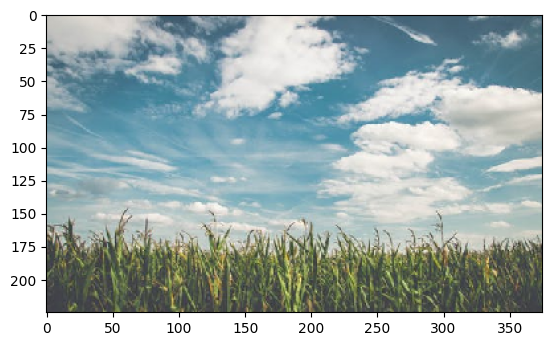

In [ ]:
plt.imshow(image)

In [ ]:
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.keras.applications.inception_v3.preprocess_input(image)

In [ ]:
run_deep_dream(network=deep_dream_model, image=image, epochs=8000, learning_rate=0.001)

Output hidden; open in https://colab.research.google.com to view.